## Linear regression <a id="1.6"></a>

So far you've learned that TensorFlow is a Numpy-like library that is GPU or TPU accelerated, with automatic differentiation. Time for an end-to-end example: let's implement a linear regression, the FizzBuzz of Machine Learning.

For the sake of demonstration, we won't use any of the higher-level Keras components like Layer or MeanSquaredError. Just basic ops.


In [3]:
! pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     -------------------- ----------------- 30.7/5

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.26

   ----------------------------- -------- 234.0/300.9 MB 454.0 kB/s eta 0:02:28
   ----------------------------- -------- 234.0/300.9 MB 453.7 kB/s eta 0:02:28
   ----------------------------- -------- 234.0/300.9 MB 453.1 kB/s eta 0:02:28
   ----------------------------- -------- 234.1/300.9 MB 453.4 kB/s eta 0:02:28
   ----------------------------- -------- 234.1/300.9 MB 452.4 kB/s eta 0:02:28
   ----------------------------- -------- 234.1/300.9 MB 452.1 kB/s eta 0:02:28
   ----------------------------- -------- 234.1/300.9 MB 451.8 kB/s eta 0:02:28
   ----------------------------- -------- 234.2/300.9 MB 451.8 kB/s eta 0:02:28
   ----------------------------- -------- 234.2/300.9 MB 450.6 kB/s eta 0:02:29
   ----------------------------- -------- 234.2/300.9 MB 450.6 kB/s eta 0:02:29
   ----------------------------- -------- 234.2/300.9 MB 450.3 kB/s eta 0:02:29
   ----------------------------- -------- 234.3/300.9 MB 449.7 kB/s eta 0:02:29
   ----------------------------- -------

In [4]:
import tensorflow as tf



In [5]:
input_dim = 2
output_dim = 1
learning_rate = 0.01

# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def compute_predictions(features):
  return tf.math.sigmoid(tf.linalg.matmul(features, w) + b)

def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

def binary_cross_entropy(y_true, y_pred):
    return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        predictions = compute_predictions(x)
        #loss = compute_loss(y, predictions)
        loss = binary_cross_entropy(y, predictions)
        dloss_dw, dloss_db = tape.gradient(loss, [w,b])
    w.assign_sub(learning_rate* dloss_dw)
    b.assign_sub(learning_rate* dloss_db)
    return loss

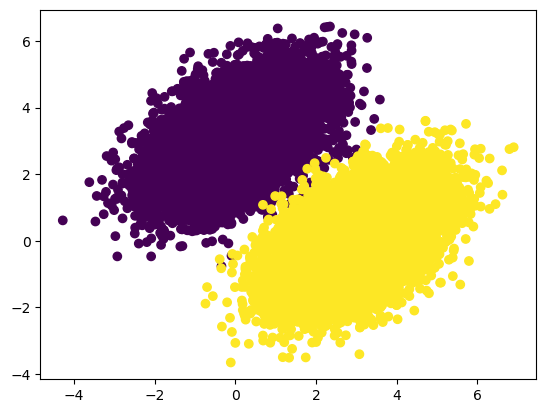

In [6]:
# Lets generate some artifical data
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

Now let's train our linear regression by iterating over batch-by-batch over the data and repeatedly calling `train_on_batch`:

In [7]:
# shuffle data
indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

# Create a tf.data.Dataset object for easy batched iteration
ds = tf.data.Dataset.from_tensor_slices((features, labels))
ds = ds.shuffle(buffer_size=1024).batch(256)

for epoch in range(10):
    for step, (x,y) in enumerate(ds):
        loss = train_on_batch(x, y)
    print(f"Epoch {epoch}: last batch loss= {float(loss)}")

Epoch 0: last batch loss= 0.4538319706916809
Epoch 1: last batch loss= 0.23440130054950714
Epoch 2: last batch loss= 0.11565585434436798
Epoch 3: last batch loss= 0.09751923382282257
Epoch 4: last batch loss= 0.08198778331279755
Epoch 5: last batch loss= 0.05726742744445801
Epoch 6: last batch loss= 0.05824872851371765
Epoch 7: last batch loss= 0.05186548829078674
Epoch 8: last batch loss= 0.05260767787694931
Epoch 9: last batch loss= 0.0400710254907608


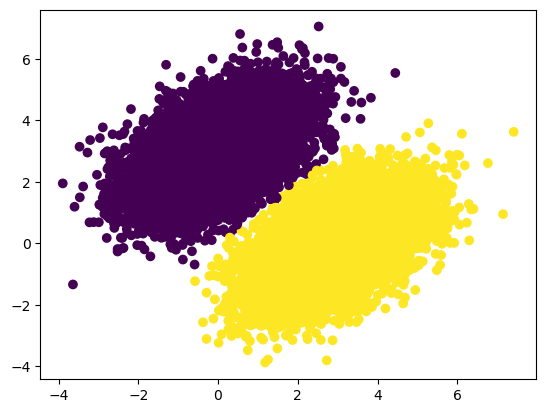

In [8]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)